# To Do 

1. Use true parameters except for delta and see if that works [Done, works -> Problem seems to be that we have no gradient and that there are WAY to little draws per second]

2. Implement gradient function [Done, works -> Now the biggest problem seems to be that there are still WAY to little draws per second]

3. Upload problem to PyMC3 discussion board / there is this one guy who answers *all* questions 

# Bayesian estimation

## Strategy 

1. From some model extract (observed) data and likelihood function 
2. To use PyMC3 for estimation implement wrapper classes around likelihood and gradient of likelihood
3. Define prior distributions for model parameters 
4. Sample from posterior and plot results

## Import Modules

In [1]:
import respy as rp
import numpy as np
import pandas as pd

import pymc3 as pm
import theano
import theano.tensor as tt
import scipy.optimize

import matplotlib.pyplot as plt

## Simulate (robinson crusoe) data 

In [2]:
theta_0, options_0, data = rp.get_example_model("robinson", with_data=True)

In [3]:
theta_0

value
category       name                       
delta          delta                 0.950
wage_fishing   exp_fishing           0.070
nonpec_fishing constant             -0.100
nonpec_hammock constant              1.046
shocks_sdcorr  sd_fishing            0.010
               sd_hammock            0.010
               corr_hammock_fishing  0.000

## Create Log-Likelihood which is dependent only on parameters (theta)

In [4]:
likelihood = rp.get_crit_func(theta_0, options_0, data)
likelihood(theta_0)

9.033443270309705

## Create wrapper class around custom Log-Likelihood

This is going to depend upon the gradient of the likelihood, which will be implemented below.

In [5]:
class LogLik(tt.Op):
    """
    Class wrapper around loglikehood s.t. PyMC3 
    can use the custom likelihood function from respy.
    Inherits from tt.Op. 
    """
    itypes = [tt.dvector]
    otypes = [tt.dscalar] 
    
    def __init__(self, loglik, theta_0, eps):   #:param_idx, theta_0):
        """
        Initialize the Op with <loglik> function and other parameters
        which are important for the evaluation.
        
        Parameters
        ----------
        loglik:
            The log-likelihood function 
        """
        
        self.likelihood = loglik
        self.theta_0 = theta_0
        self.logpgrad = LogLikGrad(loglik, theta_0, eps)
    
    def perform(self, node, inputs, outputs):
        """Method which is used when calling the Op"""

        # modify input for respy log-likelihood        
        self.theta_0.loc['delta', 'delta'] = inputs[0][0]
        #theta_0.loc['wage_fishing', 'exp_fishing'] = inputs[0][1]
        
        # compute log-likelihood value        
        logl = self.likelihood(self.theta_0)
        print("delta=", inputs[0][0], "logl=", logl) # debugging
        
        # store output
        outputs[0][0] = np.array(logl)
        
    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        
        theta, = inputs  # our parameters
        return [g[0] * self.logpgrad(theta)]

## Create wrapper class for the (approximate) gradient of Log-Likelihood

In [12]:
class LogLikGrad(tt.Op):
    """
    This Op will be called with a vector of parameter values and returns a vector 
    of values - the gradients in each dimension.
    """
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, loglik, theta_0, eps):
        """
        Initialise with various things that the function requires.
        Parameters
        ----------
        loglik:
            The log-likelihood function
        """

        # add inputs as class attributes
        self.likelihood = loglik
        self.theta_0 = theta_0
        self.epsilon = eps

    def perform(self, node, inputs, outputs):
        theta, = inputs
        
        # wrapper for loglikelihood accepting numpy arrays
        def llik(values):
            theta_0 = self.theta_0
            theta_0.loc['delta', 'delta'] = values
            return self.likelihood(theta_0)

        # approximate gradients
        grads = scipy.optimize.approx_fprime(
            xk=theta,
            f=llik,
            epsilon=self.epsilon
        )

        outputs[0][0] = grads

## Set values for MCMC simulation

In [7]:
ndraws = 50  #int(5e3)
nburn = 10  #int(1e1)

## Set Log-Likelihood

In [9]:
loglik = LogLik(likelihood, theta_0, eps=1e-4)

## Define priors and sample from Log-Likelihood using ```pyMC3```

In [10]:
with pm.Model():
    
    ## Priors; we choose very large variances to make them uninformative 
    
    # discount factor is uniform on [0, 1]
    delta = pm.Uniform('delta', lower=.5, upper=.99)
    
    # experience accumulation parameter is HalfNormal with very large variance
    #exp_fishing = pm.HalfNormal('exp_fishing', sigma=0.5)
    #exp_fishing = pm.Uniform('exp_fishing', lower=0., upper=2.)
    
    # constant priors are normal with very large variance and centered around zero
    #nonpec_fishing = pm.Normal('nonpec_fishing', mu=0., sigma=1e3)
    #nonpec_hammock = pm.Normal('nonpec_hammock', mu=0., sigma=1e3)
    
    # standard deviations are InverseGamma with very large variance
    #sd_fishing = pm.InverseGamma('sd_fishing', alpha=0.01, beta=0.01)
    #sd_hammock = pm.InverseGamma('sd_hammock', alpha=0.01, beta=0.01)
    
    # correlation is uniform on [-1, 1]
    #corr_hammock_fishing = pm.Uniform('corr_hammock_fishing', lower=-1., upper=1.)
    
    ## Parameter vector (convert parameters to tensor vector)
    theta = tt.as_tensor_variable([
        delta
    ])
    """,
        exp_fishing,
        nonpec_fishing,
        nonpec_hammock,
        sd_fishing,
        sd_hammock,
        corr_hammock_fishing
    ))
    """
    
    ## Density Distribution 
    pm.DensityDist('likelihood', lambda v: loglik(v), observed={'v': theta})
    
    
    ## Trace  
    trace = pm.sample(ndraws, tune=nburn)  #, discard_tuned_samples=True)

delta= 0.745 logl= -42.62970624057178
delta= 0.745 logl= -42.62970624057178


Only 50 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


delta= 0.745 logl= -42.62970624057178
delta= 0.745 logl= -42.62970624057178


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [delta]
Sampling 2 chains:   0%|          | 0/120 [00:00<?, ?draws/s]

delta= 0.6673882737184192 logl= -57.62887750817055
delta= 0.736382147344144 logl= -44.58286349245347
delta= 0.8678190558007677 logl= -6.244729295401801
delta= 0.6827440605134896 logl= -55.11599540825837


Sampling 2 chains:   1%|          | 1/120 [00:01<02:24,  1.21s/draws]

delta= 0.8004977610133552 logl= -28.244402681549587
delta= 0.6673882737184192 logl= -57.62887750817055
delta= 0.98999995243212 logl= 6.383636110362902
delta= 0.9683994779799372 logl= 8.659906259796298


Sampling 2 chains:   2%|▏         | 2/120 [00:02<02:21,  1.20s/draws]

delta= 0.8678190558007677 logl= -6.244729295401801
delta= 0.6673882737184192 logl= -57.62887750817055
delta= 0.6838268209627987 logl= -54.93112798912174
delta= 0.99 logl= 6.3836251440122


Sampling 2 chains:   3%|▎         | 4/120 [00:03<01:56,  1.00s/draws]

delta= 0.6838268209627987 logl= -54.93112798912174
delta= 0.99 logl= 6.3836251440122
delta= 0.685999233808966 logl= -54.55771063554691
delta= 0.99 logl= 6.3836251440122


Sampling 2 chains:   4%|▍         | 5/120 [00:04<01:59,  1.04s/draws]

delta= 0.685999233808966 logl= -54.55771063554691
delta= 0.8678190558007677 logl= -6.244729295401801
delta= 0.6934477818223093 logl= -53.24079086933283
delta= 0.9543105047513356 logl= 9.010484072181116


Sampling 2 chains:   6%|▌         | 7/120 [00:05<01:41,  1.11draws/s]

delta= 0.6934477818223093 logl= -53.24079086933283
delta= 0.9273817687170494 logl= 8.391942048500457
delta= 0.7067480282986924 logl= -50.745805417852
delta= 0.9652549572301424 logl= 8.772140032161314


Sampling 2 chains:   7%|▋         | 8/120 [00:06<01:47,  1.04draws/s]

delta= 0.7067480282986924 logl= -50.745805417852


Sampling 2 chains:   8%|▊         | 9/120 [00:07<01:23,  1.33draws/s]

delta= 0.9273817687170494 logl= 8.391942048500457
delta= 0.7190032647223692 logl= -48.304231297218166
delta= 0.9538922525593074 logl= 9.014656245802177


Sampling 2 chains:   8%|▊         | 10/120 [00:08<01:29,  1.22draws/s]

delta= 0.7190032647223692 logl= -48.304231297218166
delta= 0.9127893937115128 logl= 6.89061054885291
delta= 0.7369294000652071 logl= -44.46096280848057
delta= 0.9561068745781568 logl= 8.987938694052376


Sampling 2 chains:  10%|█         | 12/120 [00:09<01:15,  1.43draws/s]

delta= 0.7369294000652071 logl= -44.46096280848057
delta= 0.9538922525593074 logl= 9.014656245802177
delta= 0.7470589405500311 logl= -42.152374063364114
delta= 0.9580216606491553 logl= 8.956474452447729


Sampling 2 chains:  11%|█         | 13/120 [00:10<01:21,  1.31draws/s]

delta= 0.7470589405500311 logl= -42.152374063364114
delta= 0.9486681820985925 logl= 9.032171782696931
delta= 0.7715589601559775 logl= -36.14683496044373
delta= 0.942325518107119 logl= 8.973276099200952


Sampling 2 chains:  12%|█▏        | 14/120 [00:11<01:32,  1.15draws/s]

delta= 0.7470589405500311 logl= -42.152374063364114
delta= 0.9611816605096859 logl= 8.889451812855413
delta= 0.7538094948964893 logl= -40.55805190435788
delta= 0.9635187714742317 logl= 8.826719598848518


Sampling 2 chains:  12%|█▎        | 15/120 [00:12<01:38,  1.06draws/s]

delta= 0.7538094948964893 logl= -40.55805190435788
delta= 0.9651489693734812 logl= 8.775636142490253
delta= 0.7705196979450687 logl= -36.41404100207095


Sampling 2 chains:  13%|█▎        | 16/120 [00:13<01:48,  1.04s/draws]

delta= 0.9661644989284843 logl= 8.74139141543771
delta= 0.7705196979450687 logl= -36.41404100207095
delta= 0.9350626790281589 logl= 8.783302560074455
delta= 0.7886030379382547 logl= -31.60196378095379
delta= 0.927637188859223 logl= 8.408392268589383


Sampling 2 chains:  14%|█▍        | 17/120 [00:15<01:53,  1.10s/draws]

delta= 0.7886030379382547 logl= -31.60196378095379
delta= 0.9216093994054713 logl= 7.934179111037679
delta= 0.8076116858528597 logl= -26.161376957736998


Sampling 2 chains:  15%|█▌        | 18/120 [00:16<01:54,  1.13s/draws]

delta= 0.9192140218520906 logl= 7.694509744863017
delta= 0.8076116858528597 logl= -26.161376957736998
delta= 0.9215121622005735 logl= 7.924999314993446
delta= 0.8268748899368117 logl= -20.23130749680333
delta= 0.9274837837202756 logl= 8.39854584115841


Sampling 2 chains:  16%|█▌        | 19/120 [00:17<01:54,  1.13s/draws]

delta= 0.8268748899368117 logl= -20.23130749680333
delta= 0.9348975161970179 logl= 8.777077514905313
delta= 0.8455887567761418 logl= -14.052610537878225
delta= 0.9421752065301423 logl= 8.970760391250014


Sampling 2 chains:  17%|█▋        | 20/120 [00:18<01:55,  1.15s/draws]

delta= 0.8455887567761418 logl= -14.052610537878225


Sampling 2 chains:  18%|█▊        | 21/120 [00:18<01:28,  1.11draws/s]

delta= 0.9651489693734812 logl= 8.775636142490253
delta= 0.8629578612096269 logl= -7.9825518965466795
delta= 0.9652336043248125 logl= 8.77284588991444


Sampling 2 chains:  18%|█▊        | 22/120 [00:19<01:27,  1.12draws/s]

delta= 0.8629578612096269 logl= -7.9825518965466795


Sampling 2 chains:  19%|█▉        | 23/120 [00:20<01:12,  1.34draws/s]

delta= 0.9652336043248125 logl= 8.77284588991444
delta= 0.8780361304228987 logl= -2.5827393814193993
delta= 0.9545683361655792 logl= 9.007701895366827


Sampling 2 chains:  20%|██        | 24/120 [00:20<01:13,  1.31draws/s]

delta= 0.8780361304228987 logl= -2.5827393814193993
delta= 0.9687553817688939 logl= 8.646067810190566
delta= 0.8899674113759374 logl= 1.4425114756017359
delta= 0.9674144027789328 logl= 8.6969294151225


Sampling 2 chains:  21%|██        | 25/120 [00:22<01:24,  1.12draws/s]

delta= 0.8899674113759374 logl= 1.4425114756017359


Sampling 2 chains:  22%|██▏       | 26/120 [00:22<01:08,  1.37draws/s]

delta= 0.9545683361655792 logl= 9.007701895366827
delta= 0.8975097467770494 logl= 3.6555551563069564
delta= 0.9199516053703776 logl= 7.771328698681155


Sampling 2 chains:  22%|██▎       | 27/120 [00:23<01:14,  1.25draws/s]

delta= 0.8975097467770494 logl= 3.6555551563069564


Sampling 2 chains:  23%|██▎       | 28/120 [00:23<00:57,  1.60draws/s]

delta= 0.9545683361655792 logl= 9.007701895366827
delta= 0.9021007917328767 logl= 4.828667448434908
delta= 0.9431473707534341 logl= 8.986087537484533


Sampling 2 chains:  24%|██▍       | 29/120 [00:24<01:06,  1.36draws/s]

delta= 0.9021007917328767 logl= 4.828667448434908
delta= 0.959980009927633 logl= 8.917139532860874
delta= 0.904663708828189 logl= 5.410908477437612
delta= 0.9605920939516839 logl= 8.903387591221923


Sampling 2 chains:  25%|██▌       | 30/120 [00:25<01:17,  1.16draws/s]

delta= 0.904663708828189 logl= 5.410908477437612


Sampling 2 chains:  26%|██▌       | 31/120 [00:26<01:00,  1.46draws/s]

delta= 0.9431473707534341 logl= 8.986087537484533
delta= 0.9061473272295838 logl= 5.723034421546645
delta= 0.9192683964457125 logl= 7.700266654784743


Sampling 2 chains:  28%|██▊       | 33/120 [00:27<00:51,  1.68draws/s]

delta= 0.9061473272295838 logl= 5.723034421546645
delta= 0.9431473707534341 logl= 8.986087537484533
delta= 0.9070142142069674 logl= 5.896663744231588
delta= 0.9382131091322014 logl= 8.884444595623687


Sampling 2 chains:  28%|██▊       | 34/120 [00:28<01:03,  1.35draws/s]

delta= 0.9474964751001596 logl= 9.027988224529759
delta= 0.9070142142069674 logl= 5.896663744231588
delta= 0.9509860407442621 logl= 9.0319458317684
delta= 0.9075324218192069 logl= 5.997395367290418


Sampling 2 chains:  29%|██▉       | 35/120 [00:29<01:13,  1.15draws/s]

delta= 0.9333165679040296 logl= 8.712663665234937
delta= 0.9075324218192069 logl= 5.997395367290418
delta= 0.9078483321355009 logl= 6.057691119779555
delta= 0.9296275817017025 logl= 8.527785631665019


Sampling 2 chains:  30%|███       | 36/120 [00:30<01:19,  1.05draws/s]

delta= 0.9078483321355009 logl= 6.057691119779555
delta= 0.9283366857722766 logl= 8.452057568917665
delta= 0.9299264828326883 logl= 8.544497971912774
delta= 0.9080431274174583 logl= 6.0944526871567675


Sampling 2 chains:  31%|███       | 37/120 [00:31<01:26,  1.04s/draws]

delta= 0.9474964751001596 logl= 9.027988224529759
delta= 0.9080431274174583 logl= 6.0944526871567675
delta= 0.959268588088364 logl= 8.932243499304278
delta= 0.9081639953313998 logl= 6.117102910126026


Sampling 2 chains:  32%|███▎      | 39/120 [00:33<01:14,  1.08draws/s]

delta= 0.9281807897338705 logl= 8.442496035786698
delta= 0.9081639953313998 logl= 6.117102910126026
delta= 0.9198796742881383 logl= 7.763957009383775
delta= 0.9082392546516136 logl= 6.13114445971739


Sampling 2 chains:  33%|███▎      | 40/120 [00:34<01:13,  1.09draws/s]

delta= 0.959268588088364 logl= 8.932243499304278


Sampling 2 chains:  34%|███▍      | 41/120 [00:34<00:57,  1.38draws/s]

delta= 0.9082392546516136 logl= 6.13114445971739
delta= 0.9485849624086332 logl= 9.031968675805963
delta= 0.9082862096536877 logl= 6.139881103823184
delta= 0.9637105041050262 logl= 8.82100412283222


Sampling 2 chains:  35%|███▌      | 42/120 [00:35<01:08,  1.14draws/s]

delta= 0.9082862096536877 logl= 6.139881103823184
delta= 0.9634915034552192 logl= 8.827525496131198


Sampling 2 chains:  36%|███▌      | 43/120 [00:36<01:05,  1.18draws/s]

delta= 0.9083155400992566 logl= 6.14532908828395
delta= 0.9485849624086332 logl= 9.031968675805963


Sampling 2 chains:  37%|███▋      | 44/120 [00:36<00:53,  1.41draws/s]

delta= 0.9083155400992566 logl= 6.14532908828395
delta= 0.9365128870061495 logl= 8.833950766181347
delta= 0.9083338744635903 logl= 6.148730949354602
delta= 0.9557103571001264 logl= 8.993530320266206


Sampling 2 chains:  38%|███▊      | 45/120 [00:37<01:01,  1.21draws/s]

delta= 0.9083338744635903 logl= 6.148730949354602
delta= 0.9577708959467555 logl= 8.960999069594319
delta= 0.9083453402159607 logl= 6.150856940137514


Sampling 2 chains:  38%|███▊      | 46/120 [00:38<01:02,  1.19draws/s]

delta= 0.9365128870061495 logl= 8.833950766181347


Sampling 2 chains:  39%|███▉      | 47/120 [00:39<00:48,  1.51draws/s]

delta= 0.9083453402159607 logl= 6.150856940137514
delta= 0.92601264923433 logl= 8.29874220010022
delta= 0.9083525124757377 logl= 6.152186268188871
delta= 0.9486215915016833 logl= 9.032059848078458


Sampling 2 chains:  40%|████      | 48/120 [00:40<00:58,  1.23draws/s]

delta= 0.9083525124757377 logl= 6.152186268188871
delta= 0.9557614241581528 logl= 8.992828933636236
delta= 0.9083569997422909 logl= 6.15301773270409
delta= 0.9333069087812708 logl= 8.71224281421589


Sampling 2 chains:  41%|████      | 49/120 [00:41<01:06,  1.06draws/s]

delta= 0.9083569997422909 logl= 6.15301773270409
delta= 0.9462081766114157 logl= 9.020032690653803
delta= 0.9083598074552732 logl= 6.153537899980387
delta= 0.9546202196450109 logl= 9.00712293654359


Sampling 2 chains:  42%|████▏     | 50/120 [00:42<01:09,  1.00draws/s]

delta= 0.9083598074552732 logl= 6.153537899980387
delta= 0.9578122963813647 logl= 8.960260236588976
delta= 0.908361564373336 logl= 6.1538633595592644


Sampling 2 chains:  42%|████▎     | 51/120 [00:43<01:04,  1.07draws/s]

delta= 0.9546202196450109 logl= 9.00712293654359


Sampling 2 chains:  43%|████▎     | 52/120 [00:43<00:52,  1.29draws/s]

delta= 0.908361564373336 logl= 6.1538633595592644
delta= 0.9544661278071069 logl= 9.008823765149842


Sampling 2 chains:  44%|████▍     | 53/120 [00:44<00:50,  1.32draws/s]

delta= 0.9083626638039803 logl= 6.154067010008766
delta= 0.9544661278071069 logl= 9.008823765149842


Sampling 2 chains:  45%|████▌     | 54/120 [00:44<00:45,  1.46draws/s]

delta= 0.9428626699137854 logl= 8.98182944383393
delta= 0.9083626638039803 logl= 6.154067010008766
delta= 0.9083633518146927 logl= 6.154194446910608
delta= 0.9599380452414021 logl= 8.918056453771708


Sampling 2 chains:  46%|████▌     | 55/120 [00:46<00:53,  1.22draws/s]

delta= 0.9083633518146927 logl= 6.154194446910608
delta= 0.9605066957916583 logl= 8.90534925927126


Sampling 2 chains:  47%|████▋     | 56/120 [00:46<00:47,  1.34draws/s]

delta= 0.9428626699137854 logl= 8.98182944383393
delta= 0.9083637823702662 logl= 6.15427419462586


Sampling 2 chains:  48%|████▊     | 57/120 [00:47<00:44,  1.43draws/s]

delta= 0.9309607112227754 logl= 8.60003951772698
delta= 0.9083637823702662 logl= 6.15427419462586
delta= 0.951977373964429 logl= 9.028285524300983
delta= 0.9083640518135004 logl= 6.154324100244401


Sampling 2 chains:  48%|████▊     | 58/120 [00:48<00:53,  1.16draws/s]

delta= 0.9562033485728643 logl= 8.986528278969109
delta= 0.9083640518135004 logl= 6.154324100244401
delta= 0.928462747596941 logl= 8.45972043731456
delta= 0.9083642204337665 logl= 6.154355331369618


Sampling 2 chains:  49%|████▉     | 59/120 [00:49<00:57,  1.06draws/s]

delta= 0.9392781475343936 logl= 8.911617796216607
delta= 0.9083642204337665 logl= 6.154355331369618
delta= 0.9495525710966872 logl= 9.033434500142645
delta= 0.9083643259579763 logl= 6.1543748759935095


Sampling 2 chains:  50%|█████     | 60/120 [00:50<01:00,  1.00s/draws]

delta= 0.9551819690215714 logl= 9.00045338087008
delta= 0.9083643259579763 logl= 6.1543748759935095


Sampling 2 chains:  51%|█████     | 61/120 [00:51<00:48,  1.22draws/s]

delta= 0.9495525710966872 logl= 9.033434500142645
delta= 0.908364391996161 logl= 6.1543871071789145
delta= 0.9501771133343113 logl= 9.03332865601078


Sampling 2 chains:  52%|█████▏    | 62/120 [00:51<00:46,  1.25draws/s]

delta= 0.908364391996161 logl= 6.1543871071789145


Sampling 2 chains:  52%|█████▎    | 63/120 [00:52<00:37,  1.51draws/s]

delta= 0.9501771133343113 logl= 9.03332865601078
delta= 0.9083644333243337 logl= 6.15439476171221
delta= 0.9381896663484256 logl= 8.883809883927933


Sampling 2 chains:  53%|█████▎    | 64/120 [00:53<00:40,  1.38draws/s]

delta= 0.9083644333243337 logl= 6.15439476171221
delta= 0.956831041159395 logl= 8.976887504540194
delta= 0.9083644591874918 logl= 6.154399551909004


Sampling 2 chains:  54%|█████▍    | 65/120 [00:54<00:46,  1.18draws/s]

delta= 0.9584268353853658 logl= 8.948915274516121
delta= 0.9083644591874918 logl= 6.154399551909004


Sampling 2 chains:  55%|█████▌    | 66/120 [00:54<00:39,  1.37draws/s]

delta= 0.9381896663484256 logl= 8.883809883927933
delta= 0.9083644753728715 logl= 6.1544025496505


Sampling 2 chains:  56%|█████▌    | 67/120 [00:55<00:42,  1.24draws/s]

delta= 0.9271131686929857 logl= 8.374336972890024
delta= 0.9083644753728715 logl= 6.1544025496505
delta= 0.9493703449337216 logl= 9.033309023502735
delta= 0.9083644855020792 logl= 6.154404425710484


Sampling 2 chains:  57%|█████▋    | 68/120 [00:57<00:49,  1.06draws/s]

delta= 0.9556808386907225 logl= 8.993933185490711
delta= 0.9083644855020792 logl= 6.154404425710484
delta= 0.9316548139001105 logl= 8.635283365733656
delta= 0.9083644918412048 logl= 6.154405599797439


Sampling 2 chains:  57%|█████▊    | 69/120 [00:58<00:55,  1.10s/draws]

delta= 0.9443455922467888 logl= 9.001942070164143
delta= 0.9083644918412048 logl= 6.154405599797439
delta= 0.953338850243038 logl= 9.019516968650931
delta= 0.9083644958082042 logl= 6.154406334535856


Sampling 2 chains:  58%|█████▊    | 70/120 [00:59<00:58,  1.17s/draws]

delta= 0.9571901886910226 logl= 8.971017981928409
delta= 0.9083644958082042 logl= 6.154406334535856


Sampling 2 chains:  59%|█████▉    | 71/120 [01:00<00:48,  1.02draws/s]

delta= 0.953338850243038 logl= 9.019516968650931
delta= 0.9083644982907488 logl= 6.154406794334001


Sampling 2 chains:  60%|██████    | 72/120 [01:01<00:44,  1.07draws/s]

delta= 0.9533573410891576 logl= 9.019366771751894
delta= 0.9083644982907488 logl= 6.154406794334001


Sampling 2 chains:  61%|██████    | 73/120 [01:01<00:38,  1.23draws/s]

delta= 0.9533573410891576 logl= 9.019366771751894
delta= 0.9083644998450253 logl= 6.154407082206876


Sampling 2 chains:  62%|██████▏   | 74/120 [01:02<00:36,  1.26draws/s]

delta= 0.9416296469324507 logl= 8.961178251948864
delta= 0.9083644998450253 logl= 6.154407082206876
delta= 0.9083645008169994 logl= 6.1544072622283235
delta= 0.9591205374358645 logl= 8.935269859482611


Sampling 2 chains:  62%|██████▎   | 75/120 [01:03<00:41,  1.09draws/s]

delta= 0.9599268137043213 logl= 8.91830130372311
delta= 0.9083645008169994 logl= 6.1544072622283235


Sampling 2 chains:  63%|██████▎   | 76/120 [01:04<00:36,  1.21draws/s]

delta= 0.9416296469324507 logl= 8.961178251948864
delta= 0.9083645014254186 logl= 6.154407374915638


Sampling 2 chains:  64%|██████▍   | 77/120 [01:04<00:33,  1.27draws/s]

delta= 0.9298733298677477 logl= 8.541547748133716
delta= 0.9083645014254186 logl= 6.154407374915638
delta= 0.951242264284849 logl= 9.031210465064811
delta= 0.9083645018062101 logl= 6.154407445442324


Sampling 2 chains:  65%|██████▌   | 78/120 [01:06<00:38,  1.08draws/s]

delta= 0.9559944937818704 logl= 8.98955719658564
delta= 0.9083645018062101 logl= 6.154407445442324
delta= 0.9291249816234539 logl= 8.499004725687177
delta= 0.9083645020447804 logl= 6.154407489630126


Sampling 2 chains:  66%|██████▌   | 79/120 [01:07<00:42,  1.04s/draws]

delta= 0.9405566742877525 logl= 8.94025331036021
delta= 0.9083645020447804 logl= 6.154407489630126
delta= 0.9505107339146925 logl= 9.0329298352093
delta= 0.9083645021932504 logl= 6.154407517128411
delta= 0.9556769883781873 logl= 8.993985595748999


Sampling 2 chains:  67%|██████▋   | 80/120 [01:08<00:43,  1.09s/draws]

delta= 0.9083645021932504 logl= 6.154407517128411


Sampling 2 chains:  68%|██████▊   | 81/120 [01:09<00:34,  1.14draws/s]

delta= 0.9505107339146925 logl= 9.0329298352093
delta= 0.9083645022860873 logl= 6.154407534321708


Sampling 2 chains:  68%|██████▊   | 82/120 [01:10<00:33,  1.13draws/s]

delta= 0.9509718043568929 logl= 9.031982456770093
delta= 0.9083645022860873 logl= 6.154407534321708


Sampling 2 chains:  69%|██████▉   | 83/120 [01:10<00:28,  1.30draws/s]

delta= 0.9509718043568929 logl= 9.031982456770093
delta= 0.9083645023449891 logl= 6.154407545232301


Sampling 2 chains:  70%|███████   | 84/120 [01:11<00:28,  1.27draws/s]

delta= 0.939040389301411 logl= 8.905825548737253
delta= 0.9083645023449891 logl= 6.154407545232301
delta= 0.9573984470128534 logl= 8.967499316130688
delta= 0.9083645023814308 logl= 6.154407551981077


Sampling 2 chains:  71%|███████   | 85/120 [01:12<00:32,  1.07draws/s]

delta= 0.9587822009591638 logl= 8.942035383261238


Sampling 2 chains:  72%|███████▏  | 86/120 [01:12<00:25,  1.34draws/s]

delta= 0.939040389301411 logl= 8.905825548737253
delta= 0.9277405757102004 logl= 8.41497207087719
delta= 0.949796598977763 logl= 9.033492155855612
delta= 0.9557040955647882 logl= 8.993615934178578
delta= 0.9308988677517843 logl= 8.596818807655843
delta= 0.9433891843902693 logl= 8.989555312298096
delta= 0.9526592772955051 logl= 9.024453347038962
delta= 0.9568536263935197 logl= 8.97652587351879


Sampling 2 chains:  72%|███████▎  | 87/120 [01:16<00:51,  1.55s/draws]

delta= 0.9526592772955051 logl= 9.024453347038962
delta= 0.9527797516653055 logl= 9.023660633989504


Sampling 2 chains:  73%|███████▎  | 88/120 [01:17<00:42,  1.34s/draws]

delta= 0.9527797516653055 logl= 9.023660633989504
delta= 0.9409978486872561 logl= 8.949192812199259
delta= 0.958701008312121 logl= 8.94362774466195
delta= 0.9596397666113605 logl= 8.924479541132674


Sampling 2 chains:  74%|███████▍  | 89/120 [01:18<00:45,  1.46s/draws]

delta= 0.9409978486872561 logl= 8.949192812199259
delta= 0.9293311655942404 logl= 8.510916242518913
delta= 0.9508752473380357 logl= 9.03221915805549
delta= 0.9559018640165549 logl= 8.990871293316301
delta= 0.9294884390970839 logl= 8.519903920202754
delta= 0.9412219230073555 logl= 8.953553159198778
delta= 0.9510275039775757 logl= 9.031836630326305
delta= 0.9559677044653203 logl= 8.989939104706773


Sampling 2 chains:  75%|███████▌  | 90/120 [01:22<01:01,  2.04s/draws]

delta= 0.9510275039775757 logl= 9.031836630326305
delta= 0.9514042067064803 logl= 9.030670732174382


Sampling 2 chains:  76%|███████▌  | 91/120 [01:23<00:48,  1.67s/draws]

delta= 0.9514042067064803 logl= 9.030670732174382
delta= 0.9395063562812092 logl= 8.917035633005067
delta= 0.957708896911717 logl= 8.962099440236617
delta= 0.9589819887816735 logl= 8.938065669752111


Sampling 2 chains:  77%|███████▋  | 92/120 [01:24<00:46,  1.65s/draws]

delta= 0.9395063562812092 logl= 8.917035633005067
delta= 0.928103147314679 logl= 8.437698334532154
delta= 0.95004272458834 logl= 9.033421768860249
delta= 0.9557351582174731 logl= 8.993190386025697
delta= 0.9305187955243628 logl= 8.576742356420386
delta= 0.9428626709347092 logl= 8.981829459444182
delta= 0.9522738348266953 logl= 9.026754800077345
delta= 0.9566534314142449 logl= 8.979696016509763


Sampling 2 chains:  78%|███████▊  | 93/120 [01:27<00:57,  2.14s/draws]

delta= 0.9522738348266953 logl= 9.026754800077345
delta= 0.9524537676716971 logl= 9.025724668965227


Sampling 2 chains:  78%|███████▊  | 94/120 [01:28<00:45,  1.74s/draws]

delta= 0.9524537676716971 logl= 9.025724668965227
delta= 0.9406431309451877 logl= 8.942042418103869
delta= 0.9584652768470394 logl= 8.948182268462169
delta= 0.9594809815793123 logl= 8.927831803722311


Sampling 2 chains:  79%|███████▉  | 95/120 [01:30<00:42,  1.71s/draws]

delta= 0.9406431309451877 logl= 8.942042418103869
delta= 0.9290316707923365 logl= 8.49356528017507
delta= 0.9506723637965045 logl= 9.032650286595949
delta= 0.955854729037632 logl= 8.991533006865177
delta= 0.9297085957116922 logl= 8.53234472534088
delta= 0.9416027649716212 logl= 8.960687760413366
delta= 0.9513220267739531 logl= 9.030951922485452
delta= 0.9561336781388858 logl= 8.987548774991783


Sampling 2 chains:  80%|████████  | 96/120 [01:33<00:52,  2.17s/draws]

delta= 0.9513220267739531 logl= 9.030951922485452
delta= 0.9516515489214132 logl= 9.029733015890614


Sampling 2 chains:  81%|████████  | 97/120 [01:34<00:40,  1.76s/draws]

delta= 0.9516515489214132 logl= 9.029733015890614
delta= 0.9397736011416026 logl= 8.92320754586699
delta= 0.9578868413992285 logl= 8.95892174682131
delta= 0.9590979235122981 logl= 8.935728589625317


Sampling 2 chains:  82%|████████▏ | 98/120 [01:36<00:37,  1.72s/draws]

delta= 0.9397736011416026 logl= 8.92320754586699
delta= 0.928316347477213 logl= 8.450815539995455
delta= 0.9501873829361842 logl= 9.033319948508522
delta= 0.9557581673804908 logl= 8.99287383137172
delta= 0.930313150534346 logl= 8.565678823394677
delta= 0.9425620906833151 logl= 8.977127115316346
delta= 0.952050400280269 logl= 9.027927534454442
delta= 0.9565344529551234 logl= 8.98154208942237


Sampling 2 chains:  82%|████████▎ | 99/120 [01:39<00:45,  2.18s/draws]

delta= 0.952050400280269 logl= 9.027927534454442
delta= 0.9522651227256271 logl= 9.026802727383302


Sampling 2 chains:  83%|████████▎ | 100/120 [01:40<00:35,  1.77s/draws]

delta= 0.9522651227256271 logl= 9.026802727383302
delta= 0.9404382755659215 logl= 8.937773561291907
delta= 0.9583290755798969 logl= 8.950767056827047
delta= 0.9593899623666248 logl= 8.92973251656862


Sampling 2 chains:  84%|████████▍ | 101/120 [01:41<00:32,  1.73s/draws]

delta= 0.9404382755659215 logl= 8.937773561291907
delta= 0.928860542697528 logl= 8.4835092148111
delta= 0.950556393189274 logl= 9.032856592253603
delta= 0.9558293559387274 logl= 8.99188725691319
delta= 0.9298423237903346 logl= 8.539822451854489
delta= 0.941825570338515 logl= 8.964701005382642
delta= 0.9514931181888464 logl= 9.030349501909678
delta= 0.9562293348571003 logl= 8.986145072070155


Sampling 2 chains:  85%|████████▌ | 102/120 [01:45<00:39,  2.18s/draws]

delta= 0.9514931181888464 logl= 9.030349501909678
delta= 0.9517954638372894 logl= 9.029123667920224


Sampling 2 chains:  86%|████████▌ | 103/120 [01:45<00:30,  1.77s/draws]

delta= 0.9517954638372894 logl= 9.029123667920224
delta= 0.9399292900669277 logl= 8.926718763737673
delta= 0.9579904706284189 logl= 8.957043660132593
delta= 0.9591658717989386 logl= 8.934347421466297


Sampling 2 chains:  87%|████████▋ | 104/120 [01:47<00:27,  1.73s/draws]

delta= 0.9399292900669277 logl= 8.926718763737673
delta= 0.9284421372908063 logl= 8.458471768933716
delta= 0.9502727085784215 logl= 9.033238848189198
delta= 0.9557731544295038 logl= 8.992667032473735
delta= 0.9301976611686827 logl= 8.559404246616312
delta= 0.9423879360419152 logl= 8.974305024993951
delta= 0.9519198573188741 logl= 9.028558777532512
delta= 0.9564640005998959 logl= 8.98262176786053


Sampling 2 chains:  88%|████████▊ | 105/120 [01:50<00:32,  2.18s/draws]

delta= 0.9519198573188741 logl= 9.028558777532512
delta= 0.9521549960814875 logl= 9.027393130301284


Sampling 2 chains:  88%|████████▊ | 106/120 [01:51<00:24,  1.77s/draws]

delta= 0.9521549960814875 logl= 9.027393130301284
delta= 0.9403188022314417 logl= 8.935236416866614
delta= 0.9582496207687858 logl= 8.952259054764065
delta= 0.9593370993539667 logl= 8.930829459267358


Sampling 2 chains:  89%|████████▉ | 107/120 [01:53<00:22,  1.73s/draws]

delta= 0.9403188022314417 logl= 8.935236416866614
delta= 0.9287614210425938 logl= 8.47763622579705
delta= 0.9504892051027418 logl= 9.032962807798116
delta= 0.955815246307256 logl= 8.992083657045537
delta= 0.9299227169640072 logl= 8.544289257432094
delta= 0.9419564882476763 logl= 8.967003946548974
delta= 0.9515931432939544 logl= 9.029966881463363
delta= 0.9562848860534379 logl= 8.98532121468831


Sampling 2 chains:  90%|█████████ | 108/120 [01:56<00:26,  2.20s/draws]

delta= 0.9515931432939544 logl= 9.029966881463363
delta= 0.9518796672132795 logl= 9.028745179683158


Sampling 2 chains:  91%|█████████ | 109/120 [01:57<00:20,  1.83s/draws]

delta= 0.9518796672132795 logl= 9.028745179683158
delta= 0.9400204432556445 logl= 8.928746058730543
delta= 0.9580511314812197 logl= 8.955934944966854
delta= 0.9592057871055456 logl= 8.933532135311966


Sampling 2 chains:  92%|█████████▏| 110/120 [01:59<00:18,  1.81s/draws]

delta= 0.9400204432556445 logl= 8.928746058730543
delta= 0.92851629046156 logl= 8.462956770531918
delta= 0.9503229997718161 logl= 9.033183721459192
delta= 0.9557824358588302 logl= 8.992538721406804
delta= 0.9301315312445623 logl= 8.555791561773884
delta= 0.9422863836245482 logl= 8.972626279769706
delta= 0.9518433751871165 logl= 9.028910306403377
delta= 0.9564224168971733 logl= 8.98325431169453


Sampling 2 chains:  92%|█████████▎| 111/120 [02:02<00:20,  2.24s/draws]

delta= 0.9518433751871165 logl= 9.028910306403377
delta= 0.9520905053179359 logl= 9.02772565083372


Sampling 2 chains:  93%|█████████▎| 112/120 [02:03<00:14,  1.81s/draws]

delta= 0.9520905053179359 logl= 9.02772565083372
delta= 0.9402488747513897 logl= 8.933735095455244
delta= 0.9582031088223714 logl= 8.95312701139434
delta= 0.9593062331639791 logl= 8.931467586433858


Sampling 2 chains:  94%|█████████▍| 113/120 [02:04<00:12,  1.76s/draws]

delta= 0.9402488747513897 logl= 8.933735095455244
delta= 0.9287036521633429 logl= 8.474196846666793
delta= 0.9504500422739937 logl= 9.033020222993914
delta= 0.9558072371083561 logl= 8.992194952755831
delta= 0.9299706166922614 logl= 8.54694049207578
delta= 0.9420334387218463 logl= 8.968338523924244
delta= 0.951651749101641 logl= 9.029732201044789
delta= 0.956317289073898 logl= 8.984837727679674


Sampling 2 chains:  95%|█████████▌| 114/120 [02:08<00:13,  2.20s/draws]

delta= 0.951651749101641 logl= 9.029732201044789
delta= 0.9519290236506419 logl= 9.028515742045553


Sampling 2 chains:  96%|█████████▌| 115/120 [02:08<00:08,  1.78s/draws]

delta= 0.9519290236506419 logl= 9.028515742045553
delta= 0.9400738937393982 logl= 8.929925114051828
delta= 0.958086697626374 logl= 8.955281689741888
delta= 0.9592292372796409 logl= 8.9330517969459


Sampling 2 chains:  97%|█████████▋| 116/120 [02:10<00:06,  1.73s/draws]

delta= 0.9400738937393982 logl= 8.929925114051828
delta= 0.9285599388341705 logl= 8.465587025379966
delta= 0.9503525995138664 logl= 9.033148732925811
delta= 0.9557880455186555 logl= 8.992461081320805
delta= 0.9300932646019778 logl= 8.553694459785328
delta= 0.9422269917558705 logl= 8.971633153025723
delta= 0.9517985241012411 logl= 9.029110197105917
delta= 0.956397929073916 logl= 8.98362515849


Sampling 2 chains:  98%|█████████▊| 117/120 [02:13<00:06,  2.18s/draws]

delta= 0.9517985241012411 logl= 9.029110197105917
delta= 0.9520526966690772 logl= 9.027916075949344


Sampling 2 chains:  98%|█████████▊| 118/120 [02:14<00:03,  1.77s/draws]

delta= 0.9520526966690772 logl= 9.027916075949344
delta= 0.9402078909592178 logl= 8.932849557647542
delta= 0.9581758461602883 logl= 8.953633886980539
delta= 0.9592881683248807 logl= 8.931840249466372


Sampling 2 chains:  99%|█████████▉| 119/120 [02:16<00:01,  1.72s/draws]

delta= 0.9402078909592178 logl= 8.932849557647542
delta= 0.9286698820447503 logl= 8.472180586371184
delta= 0.950427147013129 logl= 9.033052256637722
delta= 0.9558026314168364 logl= 8.992258891356336
delta= 0.9299989842899241 logl= 8.548507053559309
delta= 0.9420786469030962 logl= 8.9691160172862
delta= 0.9516861136132216 logl= 9.029590969830418
delta= 0.9563362363746839 logl= 8.984554016167149


Sampling 2 chains: 100%|██████████| 120/120 [02:19<00:00,  1.16s/draws]
/home/tm/anaconda3/envs/respy/lib/python3.7/site-packages/pymc3/sampling.py:464: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
The acceptance probability does not match the target. It is 0.9831642740938232, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9883189324046654, but should be close to 0.8. Try to increase the number of tuning steps.


delta= 0.9474964751001596 logl= 9.027988224529759
delta= 0.959268588088364 logl= 8.932243499304278
delta= 0.9485849624086332 logl= 9.031968675805963
delta= 0.9365128870061495 logl= 8.833950766181347
delta= 0.9546202196450109 logl= 9.00712293654359
delta= 0.9544661278071069 logl= 9.008823765149842
delta= 0.9428626699137854 logl= 8.98182944383393
delta= 0.9495525710966872 logl= 9.033434500142645
delta= 0.9501771133343113 logl= 9.03332865601078
delta= 0.9381896663484256 logl= 8.883809883927933
delta= 0.953338850243038 logl= 9.019516968650931
delta= 0.9533573410891576 logl= 9.019366771751894
delta= 0.9416296469324507 logl= 8.961178251948864
delta= 0.9505107339146925 logl= 9.0329298352093
delta= 0.9509718043568929 logl= 9.031982456770093
delta= 0.939040389301411 logl= 8.905825548737253
delta= 0.9526592772955051 logl= 9.024453347038962
delta= 0.9527797516653055 logl= 9.023660633989504
delta= 0.9409978486872561 logl= 8.949192812199259
delta= 0.9510275039775757 logl= 9.031836630326305
delta= 0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f84e0baa7b8>,
      dtype=object)

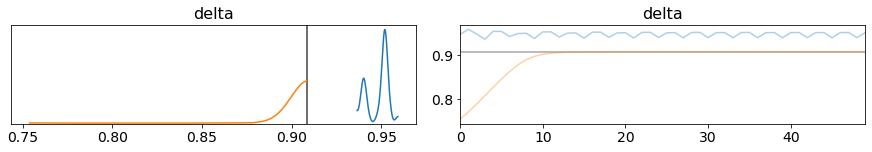

In [11]:
pm.traceplot(trace, lines=[('delta', {}, theta_0.loc['delta', 'delta'])])
#,                          ('exp_fishing', {}, theta_0.loc['wage_fishing', 'exp_fishing'])])